<a href="https://colab.research.google.com/github/DrAlexSanz/micrograd/blob/main/03_Makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of this notebook

* Following Karpathy's 4rd lecture on Makemore

https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=2435

In [1]:
import random
import torch
import torch.nn.functional as F # for later
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-01-05 14:52:12--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-01-05 14:52:13 (10.2 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# Same thing but in a function
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


### MLP definition

In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
#bngain = torch.ones((1, n_hidden))
#bnbias = torch.zeros((1, n_hidden))
#bnmean_running = torch.zeros((1, n_hidden))
#bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


### So now, let's use pytorch's functions for optimizing on one batch.

In [30]:
# Now I add the backward pass and put it in the loop, to optimize only on one batch. I should overfit quickly.

max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # build a mini batch. Like this instead of full gradient descent, we have SGD. Iterations are faster but have noise.
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # select the batch

    # Forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer previous to activation
    h = torch.tanh(hpreact) # Hidden layer after activation
    logits = h @ W2 + 2 # Output layer
    loss = F.cross_entropy(logits, Yb) # Loss

    # Backward pass
    for p in parameters:
        p.grad = torch.zeros(p.shape, dtype=torch.float32) # Set them to 0. Apparently python doesn't like None insetad of 0
    loss.backward() # calculate gradients

    # Gradient update stage
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad # lr is 0.1 here

    # track lr and loss
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item()) # Nicer plotting


      0/ 200000: 3.3036
  10000/ 200000: 2.5177
  20000/ 200000: 2.3489
  30000/ 200000: 2.1053
  40000/ 200000: 2.0258
  50000/ 200000: 2.4650
  60000/ 200000: 2.2395
  70000/ 200000: 2.0598
  80000/ 200000: 1.9662
  90000/ 200000: 2.0392
 100000/ 200000: 2.3570
 110000/ 200000: 2.1623
 120000/ 200000: 2.2415
 130000/ 200000: 2.3197
 140000/ 200000: 2.3064
 150000/ 200000: 2.2664
 160000/ 200000: 2.1873
 170000/ 200000: 2.0110
 180000/ 200000: 2.2005
 190000/ 200000: 2.0172


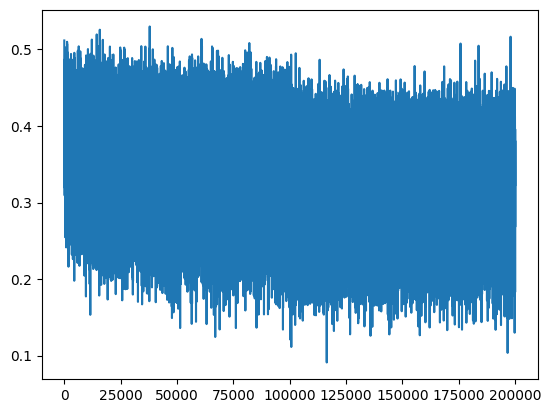

In [27]:
plt.plot(lossi)

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.463465929031372
val 3.479527235031128


In [23]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

NameError: name 'layers' is not defined